# Приоритизация гипотез и А/В тестирование

## Задача

- Вместе с отделом маркетинга интернет-магазина был подготовлен список гипотез для увеличения выручки.
- Необходимо: 
     - приоритизировать гипотезы, 
     - провести A/B-тест,
     - проанализировать результаты.
- Исследование пройдет в несколько этпов:
    - Обзор данных.
    - Предобработка данных.
    - Приоритизация гипотез.
    - Анализ A/B-теста
    - Вывод и рекомендации.




In [1]:
import matplotlib.pyplot as plt  # импорт библиотек
import numpy as np
import pandas as pd
import os
import seaborn as sns
from scipy import stats as st
import datetime as dt

## Обзор и предобработка данных

In [2]:
if os.path.exists('/datasets/hypothesis.csv'):   # чтение файлов с данными
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
else:
    hypothesis = pd.read_csv('hypothesis.csv')
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [3]:
hypothesis.info()  # получение общей информации о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


В файле представлен список гипотез . Явно что пропусков и дубликатов нет (всего 9 строчек). Необходимо изменить регистр названия столбцов.

In [4]:
# приведение названия столбцов к нормальному виду
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Описание данных

    Hypothesis — краткое описание гипотезы;
    Reach — охват пользователей по 10-балльной шкале;
    Impact — влияние на пользователей по 10-балльной шкале;
    Confidence — уверенность в гипотезе по 10-балльной шкале;
    Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [5]:
if os.path.exists('/datasets/orders.csv'):   # чтение файлов с данными
    orders = pd.read_csv('/datasets/orders.csv')
else:
    orders = pd.read_csv('orders.csv')
orders.sample(10, random_state=10)

,transactionId,visitorId,date,revenue,group
123,3268937183,3722682546,2019-08-22,1450,A
1117,3003595335,1810540789,2019-08-13,11565,B
508,2012347492,2572275626,2019-08-06,5350,B
491,298049448,3013339133,2019-08-26,2722,B
807,2740953457,3102053760,2019-08-05,990,A
507,4067849009,2108163459,2019-08-06,580,A
482,1715714627,495712671,2019-08-06,1790,A
67,459227648,2578486380,2019-08-16,2540,B
378,1964998089,2618159035,2019-08-25,5415,A
264,3795138501,887812064,2019-08-18,170,A


In [6]:
orders.info()  # получение общей информации о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


В файле дана информация по заказам. Пропусков нет. Проверим на дубликаты и приведем столбец с датой к нужному типу данных.

In [7]:
# Функция замены типа данных для столбцов с датой:
def to_date(df, *columns):
    for column in columns:
        df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')

In [8]:
to_date(orders, 'date')

In [9]:
orders.duplicated().sum()  # проверка на дубликаты

0

Описание данных

    transactionId — идентификатор заказа;
    visitorId — идентификатор пользователя, совершившего заказ;
    date — дата, когда был совершён заказ;
    revenue — выручка заказа;
    group — группа A/B-теста, в которую попал заказ.

In [10]:
if os.path.exists('/datasets/visitors.csv'):   # чтение файлов с данными
    visitors = pd.read_csv('/datasets/visitors.csv')
else:
    visitors = pd.read_csv('visitors.csv')
visitors.sample(10, random_state=10)

,date,group,visitors
20,2019-08-21,A,646
2,2019-08-03,A,507
31,2019-08-01,B,713
3,2019-08-04,A,717
6,2019-08-07,A,644
35,2019-08-05,B,707
19,2019-08-20,A,575
41,2019-08-11,B,721
53,2019-08-23,B,546
26,2019-08-27,A,711


In [11]:
visitors.info()  # получение общей информации о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


В файле дано рапределение клиентов по группам теста. Пропусков нет. Проверим на дубликаты и приведем столбец с датой к нужному типу данных.

In [12]:
to_date(visitors, 'date')

In [13]:
visitors.duplicated().sum()

0

Описание данных    
    
    date — дата;
    group — группа A/B-теста;
    visitors — количество пользователей в указанную дату в указанной группе A/B-теста

Так же проверим данные на аномальные значения, макисмумы и минимумы и интервал для дат.

In [14]:
def value(df, *columns):  # функция познакомит нас с данными в нужных колонках
    display(df.info())
    for column in columns:
        display(column)
        display(df[column].value_counts().sort_values(ascending=False))
        display('Количестово уникальных значений = {}'.format(
            len(df[column].unique())))
        display(df[column].describe(datetime_is_numeric=True))
        print('*'*20)

In [15]:
value(orders, 'revenue', 'date')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


None

'revenue'

990       17
390       13
890       13
1190      10
400       10
          ..
24350      1
1805       1
3410       1
5900       1
202740     1
Name: revenue, Length: 713, dtype: int64

'Количестово уникальных значений = 713'

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

********************


'date'

2019-08-05    48
2019-08-14    47
2019-08-12    47
2019-08-15    46
2019-08-06    46
2019-08-01    45
2019-08-28    45
2019-08-02    44
2019-08-27    44
2019-08-08    43
2019-08-19    43
2019-08-29    42
2019-08-07    42
2019-08-22    41
2019-08-09    41
2019-08-26    41
2019-08-03    40
2019-08-23    40
2019-08-10    39
2019-08-16    38
2019-08-21    37
2019-08-30    35
2019-08-13    35
2019-08-04    33
2019-08-20    32
2019-08-31    32
2019-08-24    31
2019-08-18    26
2019-08-11    26
2019-08-17    24
2019-08-25    24
Name: date, dtype: int64

'Количестово уникальных значений = 31'

count                             1197
mean     2019-08-15 13:06:46.015037696
min                2019-08-01 00:00:00
25%                2019-08-08 00:00:00
50%                2019-08-15 00:00:00
75%                2019-08-23 00:00:00
max                2019-08-31 00:00:00
Name: date, dtype: object

********************


"Отрицательных" покупок нет. В основном до 10 000р. Период анализа: август 2019г.

Проверим, что одни и те же пользователи, оформившие заказ, не попали в две разные группы (группу A и группу B), а так же равномерность распредления групп. Это необходимые условия для проведения качественного А/В тестирования.

In [16]:
visitors_checker = (visitors
                    .pivot_table(index='group',
                                 values='visitors',
                                 aggfunc='sum')
                    .reset_index()
                    )

visitors_checker['shape'] = visitors_checker['visitors'] * \
    100 / visitors_checker['visitors'].sum()
visitors_checker

,group,visitors,shape
0,A,18736,49.760969
1,B,18916,50.239031


In [17]:
# Доля группы A до удаления пользователей в обоих группах
display("Доля группы A: {0:.1f} %".format(len(orders[orders['group'] == 'A']['visitorId'].unique()) /
                                          len(orders['visitorId'].unique()) * 100))

'Доля группы A: 48.8 %'

In [18]:
# Доля группы B до удаления пользователей в обоих группах
display("Доля группы В: {0:.1f} %".format(len(orders[orders['group'] == 'B']['visitorId'].unique()) /
                                          len(orders['visitorId'].unique()) * 100))

'Доля группы В: 56.8 %'

In [19]:
orders_both_1 = (orders
                 .pivot_table(index='visitorId',
                              columns='group',
                              values='revenue',
                              aggfunc='count')
                 .reset_index()
                 .query('A >= 1 & B >= 1')
                 )
display("Доля посетителей вошедших в обе группы: {0:.1f} %".format(len(orders_both_1['visitorId'].unique()) /
                                                                   len(orders['visitorId'].unique()) * 100))
display("Количество посетителей вошедших в обе группы: {0:.0f}".format(
    len(orders_both_1)))

'Доля посетителей вошедших в обе группы: 5.6 %'

'Количество посетителей вошедших в обе группы: 58'

Распределение групп равномерно в рамках погрешности. 

Но пользователи перемешаны. 5,6% пользоватлей в выборке(или 58 человек), которые попали и в группу A, и в группу B при тестировании. Для чистоты эксперимента и выводов их следовало бы исключить. 

Так же в данных о посетителях есть суммарные данные за каждый день без распределения по ID покупателя. Исключение посетителей по ID на сновании попадания в обе группы не даст возможности скорретикровать таблицу о посещениях , что внесет ещё больше беспорядка.

В связи с этим, данные следует оставить, но принимать во внимание то, что есть погрешности в результате, связанные с попаданием одних людей в разные группы при тесте.

### Предварительные выводы

- пропусков нет 
- выполнено преобразование типов данных со значениями дат
- дубликатов нет
- определен интервал анализа - август 2019г
- выявлены некорректные значения в распределении по группам: неравномерность и "чистота" групп. 
- в остальном предположительно данные "чистые" , дополнительной обработки не требуется

## Приоритизация гипотез.

### Фреймворк ICE для приоритизации гипотез.

<font size =6>    
$\mathcal{I.C.E.Score} =\left(\frac{impact*confidence}{efforts}\right)$
 </font>

In [20]:
pd.options.display.max_colwidth = 120

In [21]:
# изменение опции показа числовых данных
pd.options.display.float_format = '{:,.2f}'.format

In [22]:
# формируем новый столбец по формуле
hypothesis['ice'] = hypothesis['impact'] * \
    hypothesis['confidence']/hypothesis['efforts']
(hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False))

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Определена тройка предварительных лидеров гипотез.

###    Фреймворк RICE для приоритизации гипотез.

<font size =6>    
$\mathcal{R.I.C.E.Score} =\left(\frac{reach*impact*confidence}{efforts}\right)$
 </font>

In [23]:
# формируем новый столбец по формуле
hypothesis['rice'] = hypothesis['reach']*hypothesis['impact'] * \
    hypothesis['confidence']/hypothesis['efforts']
(hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False))

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


Выявлены ещё 3 приоритетные гипотезы. 2 из них пересекаются с первым вариантом.

###     Изменение приоритизации гипотез.

In [24]:
# выводим общие данные
hypothesis

,hypothesis,reach,impact,confidence,efforts,ice,rice
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.00
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.00
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.00
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.20


ICE — один из самых популярных способов приоритизации задач. У этого метода есть модификация RICE. В него добавлен параметр Reach — скольких пользователей затронет изменение. Confidence показывает уверенность в оценках других параметров. Считаю целесообразным рассматривать гипотезы где эти два параметра максимальны.

### Предварительный вывод

- Самой приоритетной выделить гипотезу увеличения выручки: "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- При возможности использования ресурсов добавить в разработку гипотезу: "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"
- Так же провести первичный маркетинговый анализ гипотезы: "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей".

##  Часть 2. Анализ A/B-теста

После проведения A/B-теста были получены результаты. Изучим графики кумулятивных, или накапливаемых данных.

In [25]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date', 'group']].drop_duplicates()
# получаем агрегированные кумулятивные по дням данные о заказах
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
                                     .agg({'date': 'max', 'group': 'max', 'transactionId': 'nunique', 'visitorId': 'nunique', 'revenue': 'sum'}), axis=1).sort_values(by=['date', 'group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
                                       'date': 'max', 'group': 'max', 'visitors': 'sum'}), axis=1).sort_values(by=['date', 'group'])

# объединяем кумулятивные данные в одной таблице
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=[
                                        'date', 'group'], right_on=['date', 'group'])

cumulativeData.columns = ['date', 'group',
                          'orders', 'buyers', 'revenue', 'visitors']
cumulativeData

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736


### График кумулятивной выручки по группам.

Построим графики кумулятивной выручки по дням и группам A/B-тестирования: 

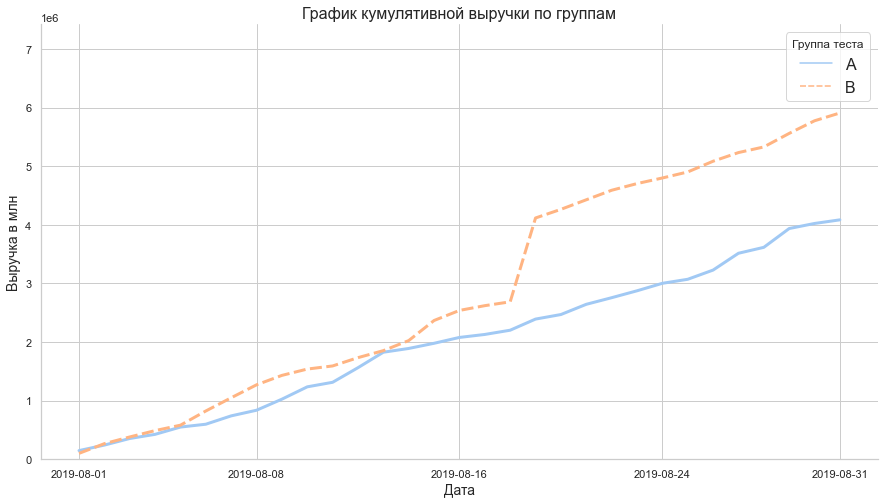

In [26]:
# Строим график выручки
plt.figure(figsize=(15, 8))
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params, palette="pastel")

sns.lineplot(x="date", y="revenue", hue='group',
             data=cumulativeData, style="group", linewidth=3.0)
# Plot formatting
plt.legend(prop={'size': 16}, title='Группа теста')
plt.title('График кумулятивной выручки по группам', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Выручка в млн', fontsize=14)
plt.xticks(['2019-08-01', '2019-08-08',
           '2019-08-16', '2019-08-24', '2019-08-31'])
plt.ylim(-0, 6*10.36**6)
plt.show()

Выручка почти равномерно увеличивается в течение всего теста.Однако графики выручки группы В имеет резкий рост. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. Такие выбросы проанализируем далее.

### График кумулятивного среднего чека по группам.

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов

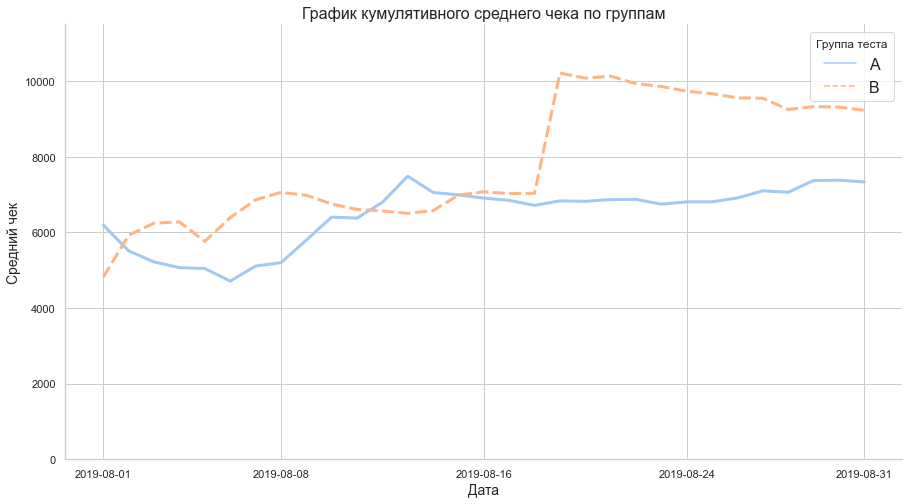

In [27]:
# добавляем необходимые вычисления
cumulativeData['avg_revenue'] = cumulativeData['revenue'] / \
    cumulativeData['orders']

# Строим график среднего чека по группам
plt.figure(figsize=(15, 8))
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params, palette="pastel")

sns.lineplot(x="date", y="avg_revenue", hue='group',
             data=cumulativeData, style="group", linewidth=3.0)
# Plot formatting
plt.legend(prop={'size': 16}, title='Группа теста', loc=0)
plt.title('График кумулятивного среднего чека по группам', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Cредний чек', fontsize=14)
plt.xticks(['2019-08-01', '2019-08-08',
           '2019-08-16', '2019-08-24', '2019-08-31'])
plt.ylim(0, 1.15*10**4)
plt.show()

Средний чек так же варьируется в узком дипазоне с постепенным ростом. Так же имется резкий вспелеск в группе B в ту же дату.  Предположение о появлении дорогого заказа подтверждается. В дальнейшем намечается тенденция к сближению средних значений. За период наблюдений чек группы А - стабилизировался, а группы В - еще нет.

### График относительного изменения кумулятивного среднего чека группы B к группе A.

Введем новые переменные с кумулятивной выручкой по дням в каждой группе

In [28]:
# датафрейм с кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][[
    'date', 'revenue', 'orders']]

# датафрейм с кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][[
    'date', 'revenue', 'orders']]

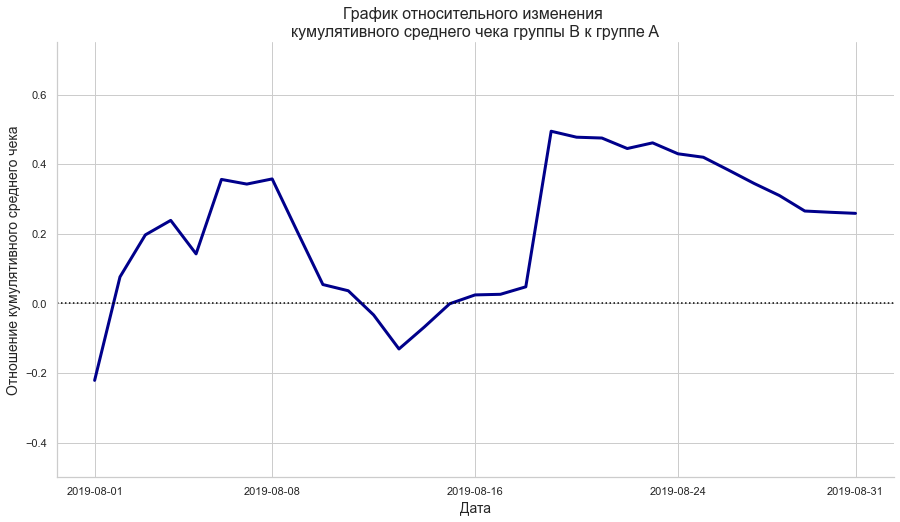

In [29]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим график отношения средних чеков
plt.figure(figsize=(15, 8))
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params, palette="pastel")

plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(
    mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1, color='darkblue', linestyle='-', linewidth=3.0)

# Plot formatting
plt.axhline(y=0, color='black', linestyle=':')
plt.title('График относительного изменения \nкумулятивного среднего чека группы B к группе A', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Отношение кумулятивного среднего чека', fontsize=14)
plt.xticks(['2019-08-01', '2019-08-08',
           '2019-08-16', '2019-08-24', '2019-08-31'])
plt.ylim(-0.5, 0.75)
plt.show()

В нескольких точках график различия между сегментами резко «скачет». Ещё одно подтверждение гипотезы о наличии крупных заказовю Дата их оформления - резкий рост на графике.

### График кумулятивного среднего количества заказов на посетителя по группам.

Анализируем график кумулятивного количества заказов

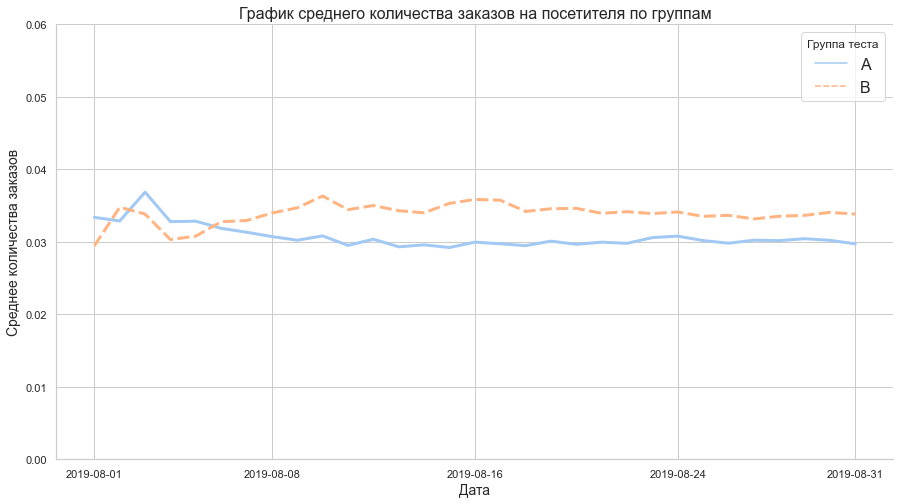

In [30]:
# считаем кумулятивное количества заказов
cumulativeData['conversion'] = cumulativeData['orders'] / \
    cumulativeData['visitors']

plt.figure(figsize=(15, 8))
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params, palette="pastel")

# Строим график  среднего количества заказов по группам
sns.lineplot(x="date", y="conversion", hue='group',
             data=cumulativeData, style="group", linewidth=3.0)

# Plot formatting
plt.legend(prop={'size': 16}, title='Группа теста', loc=0)
plt.title('График среднего количества заказов на посетителя по группам', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Среднее количества заказов', fontsize=14)
plt.xticks(['2019-08-01', '2019-08-08',
           '2019-08-16', '2019-08-24', '2019-08-31'])
plt.ylim(-0, 0.06)
plt.show()

График стабилизируется на второй декаде периода исследований. Количество заказов группы B становится стабильно выше количества заказов в группе А.

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

Введем новые переменные с кумулятивнным количеством заказов по дням в каждой группе

In [31]:
# датафрейм с кумулятивнным количеством заказов по дням в группе А
cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A'][[
    'date', 'conversion']]

# датафрейм с кумулятивнным количеством заказов по дням в группе B
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B'][[
    'date', 'conversion']]

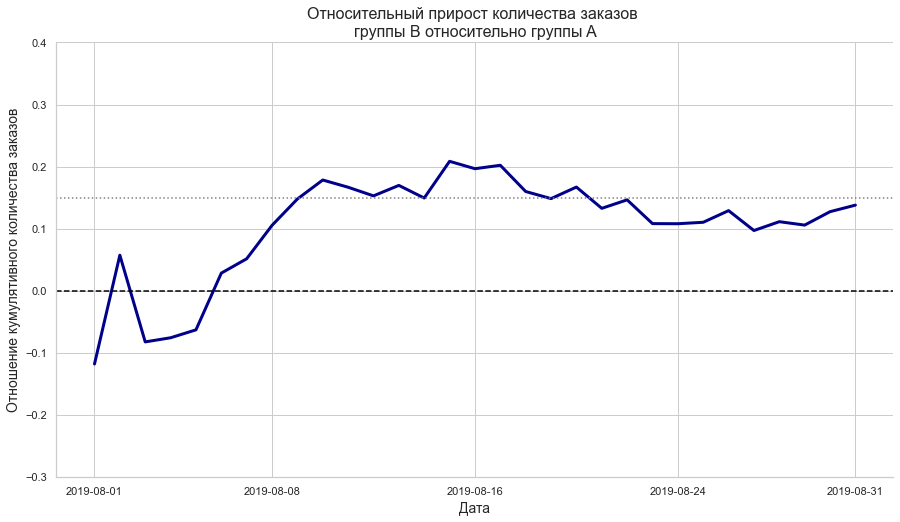

In [32]:
# собираем данные в одном датафрейме
mergedCumulativeConversions = cumulativeDataA[['date', 'conversion']].merge(
    cumulativeDataB[['date', 'conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
# cтроим отношение среднего количества заказов
plt.figure(figsize=(15, 8))
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params, palette="pastel")

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB'] /
         mergedCumulativeConversions['conversionA']-1, color='darkblue', linestyle='-', linewidth=3.0)

# Plot formatting
plt.title("Относительный прирост количества заказов \nгруппы B относительно группы A", fontsize=16)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle=':')
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Отношение кумулятивного количества заказов', fontsize=14)
plt.xticks(['2019-08-01', '2019-08-08',
           '2019-08-16', '2019-08-24', '2019-08-31'])
plt.ylim(-0.3, 0.4)
plt.show()

Имея на начальном этапе минимальные отрицательные различия группа B начиная со второй недели показывает свое преимущество в тесте. Видно стабильное превосходство (порядка 15%) этой тестовой группы.

### Точечный график количества заказов по пользователям.

Введем новую таблицу - каждому уникальному пользователю сопоставим его количество заказов

In [33]:
# датафрейм с количеством заказов по пользователям
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsers.columns = ['userId', 'orders']
ordersByUsers

,userId,orders
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1
...,...,...
1026,4266935830,2
1027,4278982564,1
1028,4279090005,1
1029,4281247801,1


In [34]:
ordersByUsers.describe()

,userId,orders
count,"1,031.00","1,031.00"
mean,"2,130,713,285.94",1.16
std,"1,228,157,182.15",0.72
min,"5,114,589.00",1.00
25%,"1,048,013,147.00",1.00
50%,"2,147,998,719.00",1.00
75%,"3,154,896,968.50",1.00
max,"4,283,872,382.00",11.00


Оценим распределение стоимости заказов графическим способом

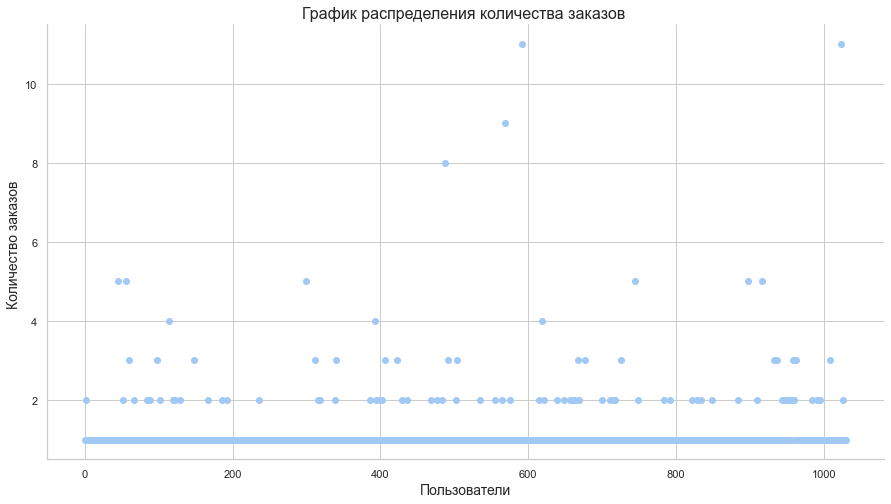

In [35]:
# строим распределение количества заказов
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.figure(figsize=(15, 8))
plt.scatter(x_values, ordersByUsers['orders'])
# Plot formatting
plt.title("График распределения количества заказов ", fontsize=16)
plt.xlabel('Пользователи', fontsize=14)
plt.ylabel('Количество заказов ', fontsize=14)
plt.show()

Предварительные выводы: основная масса пользователей с 1-2 заказами. Но точная доля с большим количеством заказов пока не ясна, и не мы не можем однозначно сказать считать их аномалиями или нет. 

### 95-й и 99-й перцентили количества заказов на пользователя. 

Принято отсеивать от 1% до 5% наблюдений с крайними значениями. 

In [36]:
# считаем перцентили
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

95% заказчиков осуществляют до 2х заказов Выберем границу для определения аномальных пользователей всех тех кто входит в оставшиеся 5%.

### Точечный график стоимостей заказов.

Посмотрим на распределение заказов по их стоимости 

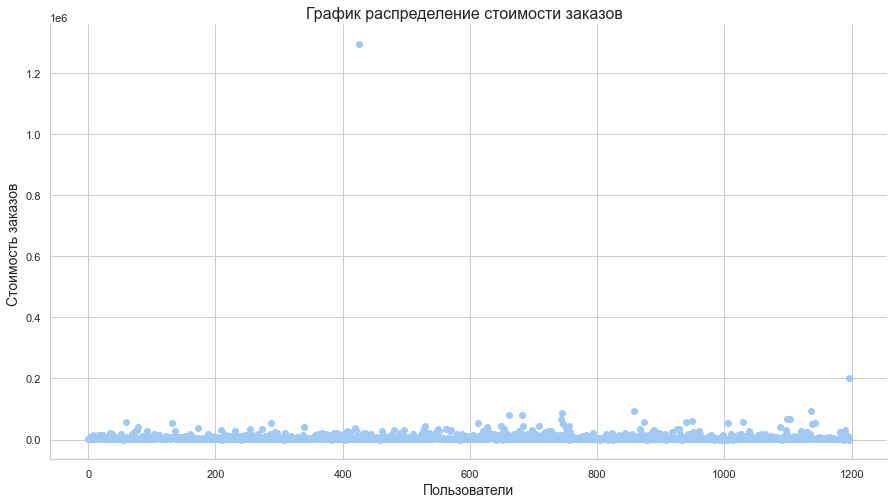

In [37]:
# строим распределение стоимости заказов
# строим распределение количества заказов
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(15, 8))
plt.scatter(x_values, orders['revenue'])
# Plot formatting
plt.title("График распределение стоимости заказов  ", fontsize=16)
plt.xlabel('Пользователи', fontsize=14)
plt.ylabel('Стоимость заказов ', fontsize=14)
plt.show()

Изменим масштаб и построим график без учёта выбросов для большей информативности по основной массе заказов

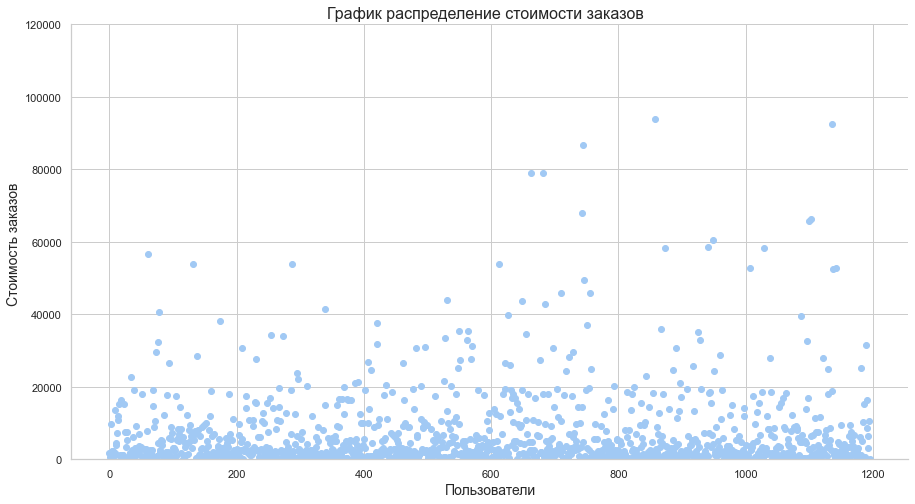

In [38]:
# строим распределение количества заказов
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(15, 8))
plt.scatter(x_values, orders['revenue'])
# Plot formatting
plt.title("График распределение стоимости заказов  ", fontsize=16)
plt.xlabel('Пользователи', fontsize=14)
plt.ylabel('Стоимость заказов ', fontsize=14)
plt.ylim(-0, 0.12*10**6)
plt.show()

Всё, как предполагали: есть немного дорогих заказов. По графику можно выбрать границу аномальных заказов от 20 000.

### 95-й и 99-й перцентили стоимости заказов.

Так же отсеим анамальные знfчения "не на глазок", а по статистическим данным.

In [39]:
# считаем перцентили
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

95% заказчиков осуществляют заказы на сумму до 28000. Так же определим границу для аномальных значений как оставшиеся 5%.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Для наших данных подойдет тест, основанный на структурном подходе, или непараметрический тест Уилкоксона-Манна-Уитни. Подготовим данные.

In [40]:
# Количество пользователей в выбранную дату в каждой группе
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# количество пользователей до выбранной даты включительно в каждой группе
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']


visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# Суммарное число заказов и суммарная выручка до выбранной даты включительно в каждой группе
ordersADaily = (
    orders[orders['group'] == 'A'][[
        'date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersBDaily = (
    orders[orders['group'] == 'B'][[
        'date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']


# Суммарное число заказов и суммарная выручка до выбранной даты включительно в каждой группе
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

In [41]:
# Число совершённых заказов для пользователей, которые заказывали хотя бы 1 раз, в каждой группе
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

Сформируем выборки в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [42]:
sampleA = pd.concat([ordersByUsersA['orders'], pd.Series(0, index=np.arange(
    visitors[visitors['group'] == 'A']['visitors'].sum() - len(ordersByUsersA['orders'])), name='orders')], axis=0)

sampleB = pd.concat([ordersByUsersB['orders'], pd.Series(0, index=np.arange(
    visitors[visitors['group'] == 'B']['visitors'].sum() - len(ordersByUsersB['orders'])), name='orders')], axis=0)

Сформулируем нулевую гипотезу $\mathcal{H₀}$ :

    - Различий в среднем количестве заказов на посетителя между группами нет.
    - Альтернативная гипотеза H₁ - Различия в среднем количестве заказов на посетителя между группами есть.

In [43]:
# проводим тест
p_value = st.mannwhitneyu(sampleA, sampleB)[1]
display("p-значение:{0:.3f}".format(p_value))

if p_value < 0.05:
    print('Отвергаем нулевую гипотезу: о том, что статистически значимых различий в количестве заказов между группами нет')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу,  о том, что статистически значимых различий в количестве заказов между группами нет'
    )

display("Относительный прирост количества заказов группы B : {0:.1f} %".format(
    (sampleB.mean() / sampleA.mean() - 1)*100))

'p-значение:0.017'

Отвергаем нулевую гипотезу: о том, что статистически значимых различий в количестве заказов между группами нет


'Относительный прирост количества заказов группы B : 13.8 %'

Предварительно по "сырым данным" всех пользователей магазина можем сделать вывод что есть статистические значимые различия количества заказов между рассматриваемыми группами. Оносительный прирост по расчетам совпадает с графиком.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным. 

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим тесту данные о выручке с заказов. 

Сформулируем нулевую гипотезу $\mathcal{H₀}$ :

    - Различий в среднем чеке заказа между группами нет.
    - Альтернативная гипотеза H₁ - Различия в среднем среднем чеке заказа между группами есть.

In [44]:
# проводим тест
results = st.mannwhitneyu(orders[orders['group'] == 'A']
                          ['revenue'], orders[orders['group'] == 'B']['revenue'])[1]
display("p-значение:{0:.3f}".format(results))

if results < 0.05:
    print('Отвергаем нулевую гипотезу: о том, что статистически значимых различий в среднем чеке заказа между группами нет')
else:
    print('Не получилось отвергнуть нулевую гипотезу,  о том, что статистически значимых \nразличий в среднем чеке заказа между группами нет')

display("Относительная разница среднего чека группы B к среднему чеку группы А : {0:.1f} %".format(
    (orders[orders['group'] == 'B']['revenue'].mean()/orders[orders['group'] == 'A']['revenue'].mean()-1)*100))

'p-значение:0.729'

Не получилось отвергнуть нулевую гипотезу,  о том, что статистически значимых 
различий в среднем чеке заказа между группами нет


'Относительная разница среднего чека группы B к среднему чеку группы А : 25.9 %'

P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. В то же время средний чек группы B значительно выше среднего чека группы A (на 25.9%). Возможно что мы случайно в этом месяце получили такие значения.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 

Мы определили аномальных пользователей тех, кто совершил больше 2 заказов или совершил заказ дороже 28 000 рублей. Уберём 5% пользователей с наибольшим числом заказов и пользователей с дорогими заказами. 
Сделаем срезы пользователей и объединим их в таблице abnormalUsers

In [45]:
# делаем срезы
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(
            ordersByUsers['orders'], [95])[0]]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(
            ordersByUsers['orders'], [95])[0]]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(
    orders['revenue'], [95])[0]]['visitorId']
# формируем таблицу
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
len(abnormalUsers)

74

Таких пользователей - 74. Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста.

In [46]:
# формируем выборки из групп
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'A']['visitors'].sum() -
                len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'B']['visitors'].sum() -
                len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Повторим нашу нулевую гипотезу $\mathcal{H₀}$ для очищенных данных:

    - Различий в среднем количестве заказов на посетителя между группами нет.
    - Альтернативная гипотеза H₁ - Различия в среднем количестве заказов на посетителя между группами есть.

In [47]:
# проводим тест
p_value_1 = st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]
display("p-значение:{0:.3f}".format(p_value_1))

if p_value_1 < 0.05:
    print('Отвергаем нулевую гипотезу: о том, что статистически значимых различий в количестве заказов между группами нет')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу,  о том, что статистически значимых различий в количестве заказов между группами нет'
    )

display("Относительный прирост количества заказов группы B : {0:.1f} %".format((
    sampleBFiltered.mean()/sampleAFiltered.mean()-1)*100))

'p-значение:0.013'

Отвергаем нулевую гипотезу: о том, что статистически значимых различий в количестве заказов между группами нет


'Относительный прирост количества заказов группы B : 17.3 %'

Результаты по среднему количеству заказов практически не изменились. После "очистки" всех пользователей магазина по-прежнему фиксируем статистические значимые различия количества заказов между рассматриваемыми группами. 

p-значение (или вероятность получить такие же или ещё более выраженные значения для подтвеждения нашей гипотезы) изменились крайне не значительно (с 0.017 до 0.013 или всего на 0.4%), а относительный прирост количества заказов группы B  вырос с 13,8% до  17.3 % (изменение на 3.5%)

Оносительный прирост по новым расчетам остается в диапазоне указанному на графике.


### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Повторим гипотезу $\mathcal{H₀}$ для среднего чека по очищенным данным:

    - Различий в среднем чеке заказа между группами нет.
    - Альтернативная гипотеза H₁ - Различия в среднем чеке заказа между группами есть.

In [48]:
# проводим тест
results_1 = st.mannwhitneyu(
    orders[
        np.logical_and(
            orders['group'] == 'A',
            np.logical_not(orders['visitorId'].isin(abnormalUsers)),
        )
    ]['revenue'],
    orders[
        np.logical_and(
            orders['group'] == 'B',
            np.logical_not(orders['visitorId'].isin(abnormalUsers)),
        )
    ]['revenue'],
)[1]
display("p-значение:{0:.3f}".format(results_1))

if results_1 < 0.05:
    print('Отвергаем нулевую гипотезу: о том, что статистически значимых различий в среднем чеке заказа между группами нет')
else:
    print('Не получилось отвергнуть нулевую гипотезу,  о том, что статистически значимых \nразличий в среднем чеке заказа между группами нет')

display("Относительная разница среднего чека группы B к среднему чеку группы А: {0:.1f} %".format(
        (orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
            / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
            - 1
        )*100)
        )

'p-значение:0.738'

Не получилось отвергнуть нулевую гипотезу,  о том, что статистически значимых 
различий в среднем чеке заказа между группами нет


'Относительная разница среднего чека группы B к среднему чеку группы А: -2.0 %'

P-value по-прежнему значительно больше 0.05. И у нас не появилось причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия. А вот средний чек группы B значительно снизился, он даже стал меньше среднего чека группы A. Наше предположение что самые дорогие заказы были в группе В получили ещё одно подтверждение (все, или почти выбросы по стоимости заказов были именно в групе В). Но при этом надо помнить что наши исходные данные по группам далеки от идеальных.

### Решение по результатам теста.
- Есть статистически значимые различия по среднему количеству заказов между группами и по «сырым», и по данным после фильтрации аномалий;
- График различия среднего количества заказов между группами сообщает, что результаты группы B лучше группы A ~ 15%;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График среднего чека по группам показывает превосходство группы В.Есть влияние выбросов
- Подсчет отношения средних значений по «сырым», и по "очищенным" данным меняется достаточно сильно.     
    
    
- Остановить тест, зафиксировать победу группы В.
    

## Выводы

Проанализированы полученные данные по итогам месяца работы интерне-магазина  
Исходная информация подготовлена для тщательного анализа

В ходе анализа проведена следующая работа:

    Выполнено преобразование типов данных со значениями дат
    Скорректированы названия столбцов в датасете
    Выявлены некорректные значения в распределении по группам: неравномерность и "чистота" групп. 

Определено и представлено в табличном виде:

    Приоритизированны гипотезы по фрейворку ICE
    Приоритизированны гипотезы по фрейворку RICE
    По итогам опредлены три наиболее качественные гипотезы для достижения увеличения выручки.
    Проведено А/В тестирование 
    95-й и 99-й перцентили количества заказов на пользователя.
    95-й и 99-й перцентили стоимости заказов.

Определено и представлено в графическом виде:    

    Кумулятивная выручка по группам.
    Кумулятивный средний чека по группам.
    Относительное изменение кумулятивного среднего чека группы B к группе A. 
    Кумулятивное среднее количества заказов на посетителя по группам. 
    Относительного изменение кумулятивного среднего количества заказов на посетителя группы B к группе A. 
    Распределение количества заказов по пользователям.
    Распредление стоимости заказов.


На основании непараметрического теста Уилкоксона-Манна-Уитни определены

    Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 
    Статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 
    Статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 
    Статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 
        
Итог анализа гипотез:
- Самой приоритетной выделить гипотезу увеличения выручки: "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- При возможности использования ресурсов добавить в разработку гипотезу: "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"
- Провести первичный маркетинговый анализ гипотезы: "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей".

Итог проведения А/В теста:
- Выручка равномерно увеличивается в течение всего теста для обеих групп.
- Средний чек обеих групп так же варьируется в узком дипазоне с постепенным ростом. 
- Количество заказов группы B по итогу рассматриваемого периода стабильно выше количества заказов в группе А.
- Оносительный прирост количества заказов в группе В стабилизировался на уровне около +15% к группе А
- 95% заказчиков осуществляют до 2х заказов/ на сумму до 28000
- Есть статистически значимые различия по среднему количеству заказов между группами
- Нет статистически значимого различия по среднему чеку между группами
- Отношение средних значений по «сырым», и по "очищенным" данным меняется достаточно сильно.Но даже после очистки данных от выбросов средний чек группы В не уступает серденму чеку группы А. 
- Отрицательное отношение среднего чека группы В к серденму чеку группы А (сумма среднего чека ниже)после очистки данных от выбровсов говорит о наличии одного или нескольких самых дорогих заказов именно в группе В
- В тесте зафиксирована победа группы В

## Рекомендации

1. Аккуратней подходить к формированию групп тестирования. Группы должны быть равноценны по количеству. в группах не должно быть пересечений участников. 
2. По возможности проведить А/А тест для опредления групп.
3. По итогам теста провести низкозатратное исследование (например анкетирование) группы В  для исключения ошибки результатов А/В тестирования.